In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
# import seaborn as sns
# from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import math
from sklearn.metrics import accuracy_score
rng = np.random.default_rng(51)
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('weatherHistory.csv')

In [4]:
date = data['Formatted Date']

In [5]:

data['Formatted Date'] = pd.to_datetime(data['Formatted Date'],  utc=True)

In [7]:
data = data[(data['Formatted Date'] >= pd.to_datetime('2010-03-01 00:00:00+01:00')) & (data['Formatted Date'] <= pd.to_datetime('2010-06-01 00:00:00+01:00'))]


In [9]:

data['year'] = data['Formatted Date'].dt.year
data['month'] = data['Formatted Date'].dt.month
data['day'] = data['Formatted Date'].dt.day
data['hour'] = data['Formatted Date'].dt.hour
data.head()

/var/folders/_4/x0mtvfq131v60xqf_dsr90z80000gn/T/ipykernel_5579/2525355818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['Formatted Date'].dt.year
/var/folders/_4/x0mtvfq131v60xqf_dsr90z80000gn/T/ipykernel_5579/2525355818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['Formatted Date'].dt.month
/var/folders/_4/x0mtvfq131v60xqf_dsr90z80000gn/T/ipykernel_5579/2525355818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,year,month,day,hour
35088,2010-03-31 22:00:00+00:00,Mostly Cloudy,rain,6.088889,3.311111,0.89,13.6689,278.0,14.9086,0.0,1009.35,Partly cloudy until evening.,2010,3,31,22
35089,2010-03-31 23:00:00+00:00,Partly Cloudy,rain,7.066667,5.900000,0.84,6.7298,267.0,9.9820,0.0,1009.84,Partly cloudy until evening.,2010,3,31,23
35090,2010-04-01 00:00:00+00:00,Partly Cloudy,rain,5.783333,4.927778,0.89,5.1520,199.0,14.9569,0.0,1014.99,Partly cloudy until evening.,2010,4,1,0
35091,2010-04-01 01:00:00+00:00,Mostly Cloudy,rain,5.494444,5.494444,0.89,3.8318,264.0,14.9086,0.0,1009.89,Partly cloudy until evening.,2010,4,1,1
35092,2010-04-01 02:00:00+00:00,Partly Cloudy,rain,5.472222,4.066667,0.86,6.6654,296.0,14.9086,0.0,1010.01,Partly cloudy until evening.,2010,4,1,2


In [10]:
quantitative = data.select_dtypes(include = ["int64","float64"]).keys()
data[quantitative].describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.000000,2209.0,2209.000000
mean,11.855656,10.867768,0.716840,12.679847,198.646899,10.613916,0.0,992.457370
std,6.698090,7.936110,0.177997,7.481667,102.623147,3.008227,0.0,151.207228
min,-5.466667,-10.944444,0.290000,0.000000,0.000000,0.289800,0.0,0.000000
25%,7.733333,5.483333,0.580000,7.116200,130.000000,9.982000,0.0,1010.630000
50%,12.194444,12.194444,0.730000,11.173400,202.000000,10.352300,0.0,1015.040000
75%,16.550000,16.550000,0.870000,16.196600,293.000000,11.398800,0.0,1020.210000
max,27.511111,27.288889,1.000000,44.146200,359.000000,16.051700,0.0,1031.440000


In [11]:
data=data.drop('Loud Cover',axis=1)

In [12]:
data['Summary'].value_counts(dropna=False)

Summary
Mostly Cloudy               753
Partly Cloudy               713
Overcast                    488
Clear                       146
Foggy                        52
Breezy and Partly Cloudy     20
Breezy and Mostly Cloudy     17
Breezy and Overcast          16
Windy and Overcast            2
Windy and Partly Cloudy       1
Breezy and Foggy              1
Name: count, dtype: int64

In [13]:

colums_to_preprocess = ['Summary', 'Precip Type', 'Daily Summary']
le = preprocessing.LabelEncoder()
for column_name in colums_to_preprocess:
    data[column_name] = le.fit_transform(data[column_name])

data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,hour
35088,2010-03-31 22:00:00+00:00,6,0,6.088889,3.311111,0.89,13.6689,278.0,14.9086,1009.35,33,2010,3,31,22
35089,2010-03-31 23:00:00+00:00,8,0,7.066667,5.900000,0.84,6.7298,267.0,9.9820,1009.84,33,2010,3,31,23
35090,2010-04-01 00:00:00+00:00,8,0,5.783333,4.927778,0.89,5.1520,199.0,14.9569,1014.99,33,2010,4,1,0
35091,2010-04-01 01:00:00+00:00,6,0,5.494444,5.494444,0.89,3.8318,264.0,14.9086,1009.89,33,2010,4,1,1
35092,2010-04-01 02:00:00+00:00,8,0,5.472222,4.066667,0.86,6.6654,296.0,14.9086,1010.01,33,2010,4,1,2


In [14]:
data = data.dropna()
X = data.drop('Temperature (C)', axis=1)
y = data['Temperature (C)']




<Axes: >

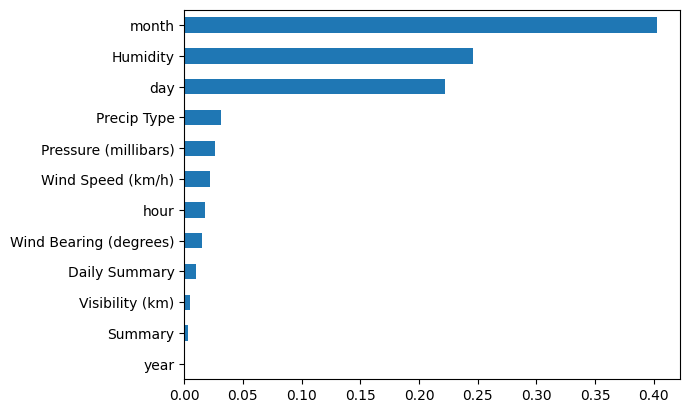

In [15]:

X.drop(columns='Apparent Temperature (C)', axis=1, inplace=True)
Xtest = X.drop(columns='Formatted Date')

from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(Xtest, y)
feat_importances = pd.Series(regr.feature_importances_, index=Xtest.columns).sort_values()
feat_importances.plot(kind='barh')


In [16]:
train_index = data[data['Formatted Date'] <= '2010-05-01'].index
test_index = data[data['Formatted Date'] > '2010-05-01'].index
X.drop(['Formatted Date'],axis=1,inplace=True)
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

In [17]:
#X = data.drop('Temperature (C)', axis=1)
#y = data['Temperature (C)']
#X.drop(['Formatted Date'],axis=1,inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=128)

In [18]:
#data.drop(['Formatted Date'],axis=1,inplace=True)

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# Создание и обучение модели регрессии
dtRegressor = LinearRegression()
dtRegressor.fit(X_train, y_train)

LinearRegression()

In [20]:
prediction = dtRegressor.predict(X_test)

In [21]:
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 12.282221755660547
R^2 Score: 0.4506367769972871


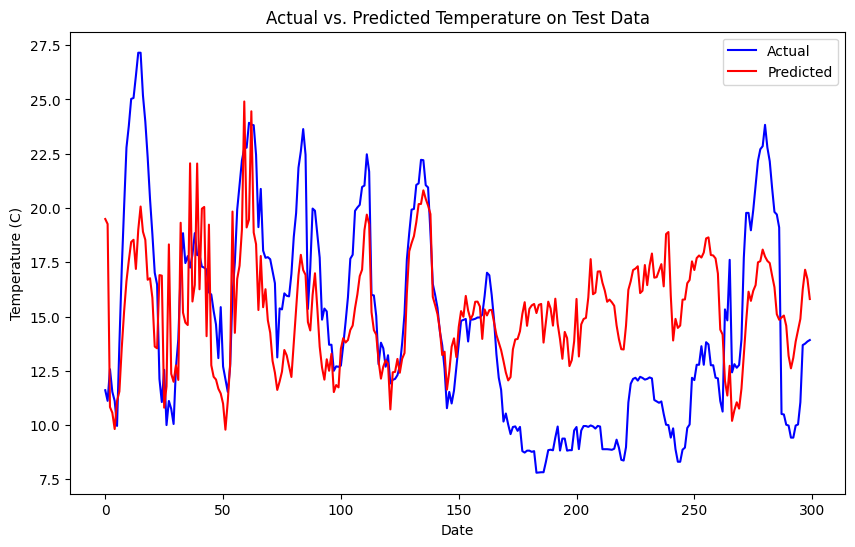

In [22]:
import matplotlib.pyplot as plt

# Создание графика
plt.figure(figsize=(10, 6))

# Построение реальных значений и предсказанных значений на тестовом наборе данных
plt.plot( y_test.values[:300], label='Actual', color='blue')
plt.plot(prediction[:300], label='Predicted', color='red')

# Добавление подписей осей и легенды
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Actual vs. Predicted Temperature on Test Data')
plt.legend()

# Отображение графика
plt.show()


In [23]:
def add_lags_and_stats(data, lag_cols, lag_interval):
    # Добавление лагов для каждого столбца
    for col in lag_cols:
        data[f'{col}_lag_{lag_interval}'] = data[col].shift(lag_interval)

    data['lags_median'] = data[lag_cols].median(axis=1)
    data['lags_max'] = data[lag_cols].max(axis=1)
    data['lags_min'] = data[lag_cols].min(axis=1)
    
    return data

In [26]:
lag_cols = ['Wind Bearing (degrees)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']  # Колонки для добавления лагов
lag_window = 10  # Размер окна лагов

data2 = add_lags_and_stats(data, lag_cols, 24)
data2 =data2.dropna()
X = data2.drop('Temperature (C)', axis=1)
y = data2['Temperature (C)']


train_index = data2[data2['Formatted Date'] <= '2010-05-01'].index
test_index = data2[data2['Formatted Date'] > '2010-05-01'].index
X.drop(['Formatted Date'],axis=1,inplace=True)
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]


# Создание и обучение модели регрессии
dtRegressor = LinearRegression()
dtRegressor.fit(X_train, y_train)

prediction = dtRegressor.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 7.901902366615706
R^2 Score: 0.6465611321521604


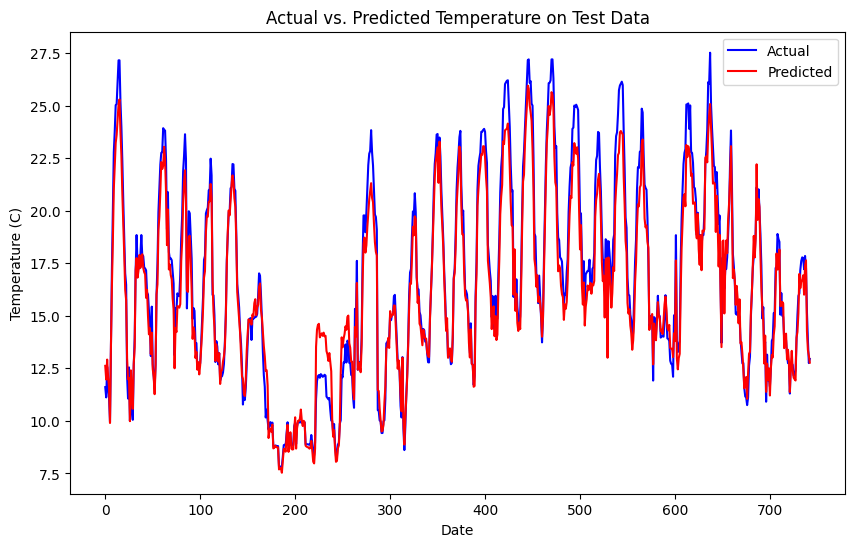

In [27]:
import matplotlib.pyplot as plt



# Создание графика
plt.figure(figsize=(10, 6))

# Построение реальных значений и предсказанных значений на тестовом наборе данных
plt.plot( y_test.values[:1000], label='Actual', color='blue')
plt.plot(prediction[:1000], label='Predicted', color='red')

# Добавление подписей осей и легенды
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Actual vs. Predicted Temperature on Test Data')
plt.legend()

# Отображение графика
plt.show()


# Сравнение методов

In [46]:

table_data = [
    ['R2', '0,8927', '0,668', '0,646'],
    ['MSE', '2,337', '7,900', '7,901']

]

# Выводим заголовок таблицы
print('|   metric  |  ARIMA    |   ЭЭС     | Regression|')
print('|-----------|-----------|-----------|-----------|')

# Выводим данные таблицы
for row in table_data:
    print(f'| {row[0]:^9} | {row[1]:^9} | {row[2]:^9} | {row[3]:^9}')


|   metric  |  ARIMA    |   ЭЭС     | Regression|
|-----------|-----------|-----------|-----------|
|    R2     |  0,8927   |   0,668   |   0,646  
|    MSE    |   2,337   |   7,900   |   7,901  
